# Lab 2: Classification (Part 1)

## Name: Hyun Do Jung (hjung35)

### Due September 9, 2020 11:59 PM

#### Logistics and Lab Submission

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html).

#### What You Will Need To Know For This Lab

This lab covers some basic classifiers which can be used for M-ary classification.

- Bayes Classifiers
- Linear Discriminant Analysis
- k-Nearest Neighbors

There are some problems which have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

<b>Also, be clear about your answers</b>. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in comparison to the alternatives. 

#### Preamble (Don't change this)

In [1]:
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data needed for Problems 1-3 

# Read the data
traindata_tmp= genfromtxt('train.csv', delimiter=',')
valdata_tmp= genfromtxt('val.csv', delimiter=',')

#The data which you will use to train LDA and kNN is called "trainingdata"
trainingdata=traindata_tmp[:,:2]
#The corresponding labels are in "traininglabels"
traininglabels=traindata_tmp[:,2]

#The data which you will use to validate LDA, kNN and the Bayes Classifier
#is called "valdata"
valdata=valdata_tmp[:,:2]
#The corresponding labels are in "vallabels"
vallabels=valdata_tmp[:,2]

In [3]:
# Some code to visualize decision regions in Problem 1 to 3; you don't need to look at this
adp=np.vstack([trainingdata,valdata])
xmin,xmax = adp[:,0].min()-1, adp[:,0].max()+1
ymin,ymax = adp[:,0].min()-1, adp[:,0].max()+1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.05),np.arange(ymin, ymax, 0.05))
drdata= np.c_[xx.ravel(), yy.ravel()]

#### Problem 1 : Bayes Classifiers (20 points + 5 bonus points)

In this section, you will implement a Bayes classifier for the following $M$-ary classification problem:

$$H_y: \mathbf{X} \sim \mathcal{N}(\mathbf{\mu}_y,{\sf C}) \qquad y=0,\ldots,M-1$$

i.e. the data is a $d$-dimensional Gaussian with a common covariance matrix $\sf C$ among all classes, but the means are different (and there is a prior among the classes). Remember, when the mean vectors, covariance matrix and prior probabilities are known, no classifier can do better than the Bayes classifier.

You will write a function which takes in 4 parameters:
* A set of data to classify (with rows as feature vectors) as a $(V,d)$ numpy.ndarray (data)
* A M-length vector with the prior probabilities of each class as a numpy.ndarray (pi)
* A matrix with rows giving the class means as a $(M,d)$ numpy.ndarray (means)
* The common covariance matrix as a $(d,d)$ numpy.ndarray (cov)

It will output a length $V$ numpy.ndarray of the outputs of the classifier (labels). You may not use scikit-learn or similar to implement this. Note that the class labels in this problem are $0,1,2$ (not $1,2,3$). Since Python uses zero-based indexing, this will allow you to avoid a few +1's in your code. 

<b>Note that there are 5 bonus points for not using loops in Problem 1.</b>

Some hints
* If you did lab 1, exercises 5 and 6, they will get you through the bulk of this problem.
* A non-exhaustive list of useful functions: numpy.linalg.inv, numpy.sum, numpy.log, numpy.argmax.
* You may use <a href="http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html">broadcasting</a> to help simplify your code. The basic form you may want to use is, if you have code which says A + B where A is (n,m) and B is (m,) then numpy will automatically translate this to adding B to each row of A. 


A function prototype is provided below <b>(10 points)</b>:

In [4]:
def bayesClassifier(data,pi,means,cov):
    # Referrence: Lecture notes #2
    # find M-ary, M by using len function
    # Reshaping for quicker calculation in general 
    # @ is a Matrix Multiplication;
    # this is the hardest part out of all to be honest 
    M = len(pi)

    # 1st term in the lecture notes
    term_one = np.log(pi) 
    term_one = term_one.reshape(M, 1)

    # 2nd term in the lecture notes
    term_two = ((means@np.linalg.inv(cov))@np.transpose(data))

    # 3rd term in the lecture notes 
    term_three = (0.5)*((means@np.linalg.inv(cov))@np.transpose(means))
    term_three = np.diag(term_three).reshape(M, 1)
    
    result = term_one + term_two - term_three
    result = np.transpose(result)

    return np.argmax(result, 1)

Now, you will write a function which calculates the error of a classifier using the $0,1$-loss by comparing the true labels and the predicted labels. 

The function will take in two parameters:
* A vector of length $N$ with the true labels as a numpy.ndarray (truelabels)
* A vector of length $N$ with the estimated labels as a numpy.ndarray (estimatedlabels)

The function will return the error (a scalar).

A function prototype is provided below <b>(5 points)</b>:

In [5]:
def classifierError(truelabels,estimatedlabels):
    # total number of samples
    num_samples = np.shape(truelabels)[0]
    
    # number of mismatch
    num_error = 0 
    
    # if labels are different, we increment the error counter, num_error
    for i in range(num_samples):
        if(truelabels[i] != estimatedlabels[i]):
            num_error += 1
                
    return num_error / num_samples

Now, we will load some sample data, in the format specified above. 
We have three classes, with
$$\pi_0=\frac{1}{4}, \pi_1=\frac{1}{4}, \pi_2=\frac{1}{2}$$

$$\mathbf{\mu}_0=\begin{bmatrix} 1 \\ 5\end{bmatrix},\mathbf{\mu}_1=\begin{bmatrix} 5 \\ 0\end{bmatrix}, \mathbf{\mu}_2=\begin{bmatrix} -2\\-2\end{bmatrix} $$

$$\Sigma=\begin{bmatrix} 5 & 1 \\ 1 & 5 \end{bmatrix}$$


In [6]:
# The prior information
pi=np.array([1/4,1/4,1/2])
means=np.array([[1,5],[5,0],[-2,-2]])
cov=np.array([[5,1],[1,5]])
# The data which you will use to test the classifier is called "data"
data=np.copy(valdata)
# The labels are in "truelabels"
truelabels=np.copy(vallabels)

Let's visualize the data by class. Each class will be in a different color.

(-7.335925, 11.615425, -8.52579, 11.99999)

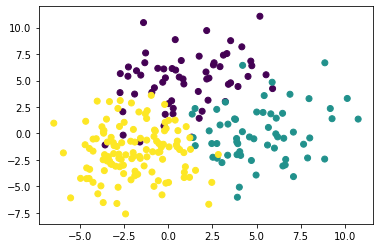

In [7]:
scatter(data[:,0], data[:,1], c=truelabels)
axis('tight')

Run the classifier on the data in `data` with labels `truelabels`. Store the predicted labels in a variable called `estimatedlabels` and report the classifier's error rate. Also, run the classifier on the data in `drdata` and store the labels outputted by the classifier into a variable called `drB`. We will use `drB` to help visualize the decision regions. <b>(5 points)</b>

In [8]:
estimatedlabels = bayesClassifier(data, pi, means, cov)
error = classifierError(truelabels, estimatedlabels)
drB = bayesClassifier(drdata, pi, means, cov)

**[ Error rate: 0.09583333333333334]**

Now, lets visualize the output of our classifier. 

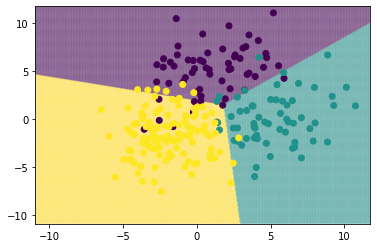

In [9]:
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(data[:,0],data[:,1],c=truelabels)

You should observe linear boundaries between the decision regions and almost all the points are in the correct region for this problem. 

#### Problem 2 : Linear Discriminant Analysis (25 points)

In this problem, you will implement Linear Discriminant Analysis (LDA). You will use the Bayes classifier from Problem 1 to do this. You will be given:
* Training data feature vectors as a $(N,d)$ numpy.ndarray (trainfeat), where each row is a feature vector.
* Training data labels as a length $N$ numpy.ndarray (trainlabel)

The first function you will write will return a tuple of the estimates of the prior probabilities (as a $M$ length numpy.ndarray), means (as a $(M,d)$ numpy.ndarray) and covariance matrix (as a $(d,d)$ numpy.ndarray) in the LDA model. You may assume that labels $0,\ldots,$trainlabel.max() exist in order to avoid some error checking. 

A hint:
* You can use logical operations+slicing to index an array. For example, if you want to get all training feature vectors whose  labels are `i`, you can use `trainfeat[trainlabel==i]`

A function prototype is provided below: <b>(10 points)</b>

In [10]:
def trainLDA(trainfeat,trainlabel):
    nlabels=int(trainlabel.max())+1 #Assuming all labels up to nlabels exist.
    pi=np.zeros(nlabels) # store your prior in here
    means=np.zeros((nlabels,trainfeat.shape[1])) # store the class means in here
    cov=np.zeros((trainfeat.shape[1],trainfeat.shape[1])) # store the covariance matrix in here
    
    # pi and means
    for i in range(nlabels):
        # pi = Nl / N, in the lecture#3
        pi[i] = sum(trainlabel==i) / len(trainingdata)     
        means[i, :] = sum(trainfeat[trainlabel==i], 0) / sum(trainlabel==i)

    # covariance, in the lecture#3    
    for i in range(len(trainingdata)):
        yi = int(trainlabel[i])
        xi_minus_mu = (trainfeat[i] - means[yi, :]).reshape(len(trainingdata[0]), 1)
        cov += (xi_minus_mu @ np.transpose(xi_minus_mu))
        
    cov /= (len(trainingdata) - nlabels)
        
    return (pi,means,cov)

Our training data is in a numpy array called `trainingdata`, with corresponding labels `traininglabels`. Our validation data is in a numpy array called `valdata`, with corresponding labels `vallabels`. The data format is the same as Problem 1. 

And we can visualize the training data:

(-10.915685, 10.307385, -9.623230000000001, 11.708630000000001)

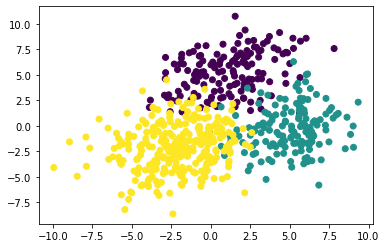

In [11]:
# We will use the following code to visualize the decision regions of the classifier.
# You don't need to look at this cell.

scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
axis('tight')

Use the bayesClassifier function you wrote in Problem 1 along with the trainLDA function from Problem 2 to implement the LDA classifier. Train the LDA classifier on the training data in `trainingdata`, and then run the LDA classifier on the training data and the validation data. Store the predicted training labels in `estimatedtraininglabels` and the predicted labels on the validation data in `estimatedvallabels`. Print out the prior, means and covariance estimated in LDA. (And don't forget to run your LDA classifier on the data in `drdata` and store the resultant predicted labels in `drLDA` to help visualize the output of the classifier.) <b>(5 points)</b>

In [12]:
# Put your code here
[pi, means, cov] = trainLDA(trainingdata, traininglabels)
print("prior: ", pi)
print("means: ", means)
print("cov: ", cov)

estimatedtraininglabels = bayesClassifier(trainingdata, pi, means, cov)
estimatedvallabels = bayesClassifier(valdata, pi, means, cov)

drLDA = bayesClassifier(drdata, pi, means, cov)

prior:  [0.25 0.25 0.5 ]
means:  [[ 1.12191279  5.17315581]
 [ 4.91358665 -0.28614234]
 [-2.07276858 -2.11161245]]
cov:  [[4.67512737 1.04472481]
 [1.04472481 4.79078813]]


The training data is generated with the distribution used in Problem 1, so your $\pi, \mu, {\sf C}$ should all be pretty close to the ones given in Problem 1. If they are not close, you've done something wrong. 

Now, calculate the errors. Report the training error (error of the classifier on the training data) and the validation error (error of the classifier on the validation data). <b>(5 points)</b>

In [13]:
# Put your code here
t_error = classifierError(traininglabels, estimatedtraininglabels)
v_error = classifierError(vallabels, estimatedvallabels)
print("Training error: ",t_error)
print("Validation error: ",v_error)

Training error:  0.07333333333333333
Validation error:  0.10833333333333334


**[Training error:  0.07333333333333333
Validation error:  0.10833333333333334]**

We can also visualize the performance of the classifier on the training and validation data. In this problem, both the training and validation data was generated from the distributions specified in Problem 1, so we show both the LDA classifier (which you learned from the data) and the Bayes classifier (which assumed you knew the true joint distribution of the data and the labels). 

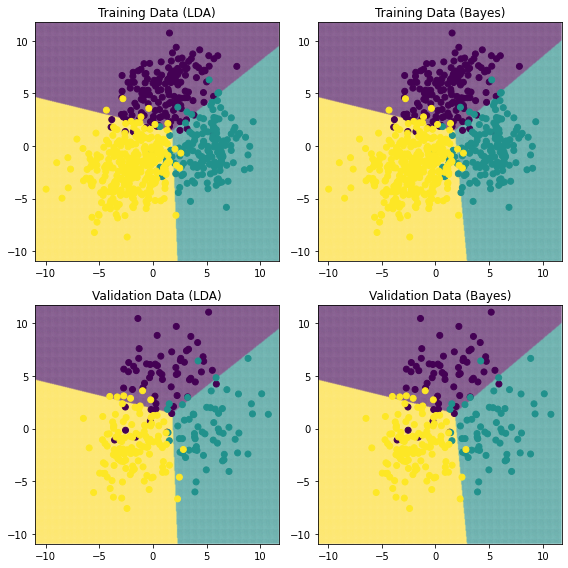

In [14]:
figure(figsize=(8, 8)) # If this is looking a bit squished, you can change the 8 (width) and 8 (height)
subplot(2,2,1)
pcolormesh(xx,yy,drLDA.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (LDA)')
subplot(2,2,2)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (Bayes)')
subplot(2,2,3)
pcolormesh(xx,yy,drLDA.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (LDA)')
subplot(2,2,4)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (Bayes)')
tight_layout()

Most of the points should be correctly classified in both the training and validation data. If they are not, you've done something wrong. 

In this problem, we see that the LDA classifier gives boundaries which are quite similar to the Bayes classifier (assuming you've implemented both correctly). If you had a lot of training data from an <b>arbitrary distribution</b>, would you expect the LDA classifier to give similar boundaries to the Bayes classifier? Why or Why not? <b>(5 points)</b>

**[ SHORT ANSWER: The key point that LDA holds is that feature vectors from the training set of data have different mean values while having the SAME covaraince values which implies that arbitrary distribution would result worse classified result because LDA is for liniear classificaiton; Gaussian Mixture Model is rather fit for arbitrary distributioin ]**

#### Problem 3: k-Nearest Neighbors + Some Short Answer Questions (35 points)

In this problem, you will implement the k-Nearest Neighbors algorithm.

The following imports are copied from the beginning for your benefit.

In [15]:
import scipy.spatial.distance as dist
from scipy import stats

Your function will take:
* Training data feature vectors as a $(N,d)$ numpy.ndarray (trainfeat), where each row is a feature vector
* Training data labels as a length $N$ numpy.ndarray (trainlabel)
* Test data feature vectors as a $(V,d)$ numpy.ndarray (testfeat), where each row is a feature vector
* The value of k

Use the Euclidean distance (scipy.spatial.distance.cdist) as your dissimilarity measure. Read the documentation!

Your function should return a length $V$ numpy.ndarray vector of the estimated labels. This should take around 4 lines of code. Do not use the kNN implementation in scikit-learn or similar.

Some functions which may be useful (read the documentation!):
* The numpy.argpartition function can be used to find the $k$ smallest elements of an array (via slicing)
* scipy.stats.mode can find the most common element in an array. Check the output.

<b>(10 points)</b>

In [16]:
def kNN(trainfeat,trainlabel,testfeat, k):
    euc_dist = dist.cdist(testfeat, trainfeat, 'euclidean')
    indices = np.argpartition(euc_dist, k, 1)[:,:k]
    [label, count] = stats.mode(trainlabel[indices], 1)
    
    return label

Run your k-Nearest Neighbors classifier with the training data in `trainingdata` and validation data in `valdata` from Problem 2, for $k=1,3,4,5$. Compute the training and validation error rates on the data from Problem 2. <b>(5 points)</b>

In [17]:
# define k arrays
k = [1, 3, 4, 5]
for k in k:
    print("k: ", k)    
    knn = kNN(trainingdata, traininglabels, trainingdata, k)
    print("Training Error : ", classifierError(knn, traininglabels))
    
    knn = kNN(trainingdata, traininglabels, valdata, k)
    print("Validation Error : ", classifierError(knn, vallabels))

k:  1
Training Error :  0.0
Validation Error :  0.1125
k:  3
Training Error :  0.056666666666666664
Validation Error :  0.10833333333333334
k:  4
Training Error :  0.06333333333333334
Validation Error :  0.10833333333333334
k:  5
Training Error :  0.06
Validation Error :  0.1


Which value of k would you choose for the k-NN classifier? Why? Run your k-NN classifier with the chosen value of k on  the data in `drdata` and store the result in a variable called `drK`. <b>(5 points)</b>

**[ Short Answer: Since smallest validation error percentage is lowest, I would choose k=5 for my NN classifier with the observation with a trend that validation slightly decreases as more k's ]**

In [18]:
k=5 # Put the value of k you would choose in the variable k.
drK=kNN(trainingdata,traininglabels,drdata,k)

Now, let us visualize the decision boundaries of your chosen value of $k$. 

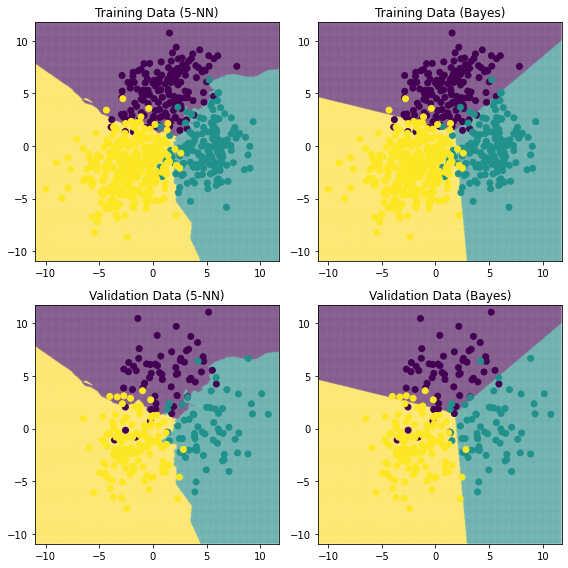

In [19]:
figure(figsize=(8, 8)) # If this is looking a bit squished, you can change the 8 (width) and 8 (height)
subplot(2,2,1)
pcolormesh(xx,yy,drK.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (%i-NN)'%k)
subplot(2,2,2)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(trainingdata[:,0],trainingdata[:,1],c=traininglabels)
title('Training Data (Bayes)')
subplot(2,2,3)
pcolormesh(xx,yy,drK.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (%i-NN)'%k)
subplot(2,2,4)
pcolormesh(xx,yy,drB.reshape(xx.shape),alpha=0.1,antialiased=True)
axis('tight')
scatter(valdata[:,0],valdata[:,1],c=vallabels)
title('Validation Data (Bayes)')
tight_layout()

**Some Short Answer Questions**

(1) The training and validation data used in problems 1-3 was all drawn from the distribution described in problem 1.  Compare and contrast the results you got from LDA and k-Nearest Neighbors as well as the Bayes classifier from problem 1. Your answer should consider both computational resources as well as error performance. <b>(5 points)</b>

**[ Short Answer: Because we do not have to train data while having a very low error rate, Bayes Classifier is the best classifier among three methods following by LDA which is a lot similar to Bayes Classifier with one more step of training data. On the other hand, Bayes classification requires prior probabilities while other two need an extra step of training data sets. In addition, knn was though the most intuitive method out of all. ]**

(2) Compared to other values of k in k-NN, why the training error is zero when you use the standard nearest neighbor (1-NN) algorithm?  <b>(5 points)</b>

**[ Short Answer: when k is 1, this simply means that 1-nn classifies the nearest point for each sample is itself that also implies it perfectly fits which result out an error of zero value. ]**

(3) Assuming you did not have knowledge of the true distribution of the data, out of the classifiers discussed in problems 1-3 (Bayes, LDA, kNN with the k you selected above), which classifier would you prefer in this problem? Why? <b>(5 points)</b>

**[ Short Answer: Because we do not have prior information and distribution information, Bayes classifier cannot be used and so is LDA which assumes a same covariance matrix under a Gaussian distribution with linear boundaries, thus kNN classfier is the only option we can try that has no certain limitation. ]**

#### Problem 4: LDA and kNN using scikit-learn <b>(20 points)</b>

In many cases, you will be using other people's libraries to implement learning algorithms. In this problem, you will become familiar with scikit-learn's implementation of LDA and kNN.

First, we will load a data set of digits drawn from zip codes written on US mail. This data set was designed to help get good algorithms to sort mail by zip code automatically. It has been preprocessed a bit, with details given <a href="http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.info.txt">here</a>. Each feature vector consists of $16^2$ real values representing grayscale values of a 16 by 16 image of a digit. The training data has 7291 samples, while the validation data has 2007 samples. Note that this is not the same dataset built into scikit-learn -- it is much larger. 

In [20]:
#Loading the Data

#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ') 

#The training labels are stored in "trainlabels", training features in "traindata". Rows are feature vectors.
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]

#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ') 

#The validation labels are stored in "vallabels", validation features in "valdata". Rows are feature vectors.
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to run a Nearest Neighbor classifier (1-NN) on the validation data with the provided training set. Note that KNeighborsClassifier defaults to 5-NN. 

Measure the time for fitting the model and classification (the %timeit feature or time() or similar will be useful). Try the different algorithms possible to fit the model (ball tree, kd-tree and brute force, and specify the fastest one in your code). Make sure to calculate the error on the validation set.  <b>(5 points)</b>

In [21]:
from sklearn import neighbors
import time


# auto is default, so decided not to put it in 
alg = ["ball_tree", "kd_tree", "brute"] 

for method in alg:
    one_nn = neighbors.KNeighborsClassifier(n_neighbors = 1, algorithm = method)
    print("Method : ", method)
    
    start = time.time()
    one_nn.fit(traindata, trainlabels)
    print("Time to fit : ", time.time() - start)
    
    start = time.time()
    labels = one_nn.predict(valdata)
    print("Time to classify : ", time.time() - start)    
    
    error = classifierError(labels, vallabels)
    print("Error : ", error)
    

Method :  ball_tree
Time to fit :  0.2182309627532959
Time to classify :  4.728682994842529
Error :  0.05630293971101146
Method :  kd_tree
Time to fit :  0.24521183967590332
Time to classify :  5.355654001235962
Error :  0.05630293971101146
Method :  brute
Time to fit :  0.003529071807861328
Time to classify :  0.25661611557006836
Error :  0.05630293971101146


**[ Short Answer: The least time method for fitting and classifying is Brute force method which gives me the error about 0.0563 as shown above. ]**

Now, run LDA on the validation data set with scikit-learn's sklearn.discriminant_analysis.LinearDiscriminantAnalysis class. Measure the training time as well as the time used to classify the validation set. Make sure to calculate the error on the validation set.  <b>(5 points)</b>

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

start = time.time()
lda.fit(traindata, trainlabels)
print("Time to fit : ", time.time() - start)

start = time.time()
labels = lda.predict(valdata)
print("Time to classify : ", time.time() - start)

error = classifierError(labels, vallabels)
print("Error : ", error)

Time to fit :  0.2952110767364502
Time to classify :  0.0017879009246826172
Error :  0.114598903836572


**[ Short Answer: Time takes for fitting and classifying is 0.39067 and 0.00158167 seconds and the error value is 0.1145989. ]**

(1) Based on the performance on the validation set, which algorithm would you pick (for this particular problem)? Your answer should also take into account computational resources required, error on the validation set, and the cost associated with making an error (in real life -- recall the source of the data). <b>(5 points)</b>

**[ Short Answer: Based on the performance on the set, intuitively chosen method would be 'brute force' k-NN classifier which has lowest classification error and pretty fast in classifying and fitting the data. This is critical in postal service because misclassification can cause delays in the delivery process. In resource-wise and real-world problem, this play a huge role which decides the cost of taking care of such error like misclassification. ]**

(2) Do you think the 0,1-loss is appropriate error measure in this case? Why or why not? How can you use domain-specific knowledge to help improve performance for this application?

If you are interested in this in more detail on this problem, see O. Matan et al., "Reading Handwritten Digits: A ZIP Code Recognition System", IEEE Computer, Vol 25, Number 7, pp 59-63, 1992 (<a href="http://yann.lecun.com/exdb/publis/pdf/matan-92.pdf">tech report version here</a>). You do not need to look at this to answer the question. <b>(5 points)</b>

**[ Short Answer: I do not think  0,1-loss indicator may not be the appropriate in this problem because we are dealing with digit numbers for zip code that offset would cause much difference in real world that would definitely increase the resources handling cost. As a result, domain-specific knowledge is critical choosing which classification methods we are going to choose to use to improve the performace of classification process. For this current example, if we have other information such as address or area specific information, we can compare and check over our classification with the given information to verify that our classified label is correct or not. ]**

## And this concludes Lab 2! Congratulations!